# Initialization

## Import

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn import metrics

from skimage import io
from skimage import segmentation
from skimage import morphology
from skimage import measure
from skimage import transform
from skimage import img_as_float
from skimage import data as skdata

## Read single-channel two-class

(417, 500) 237 12
(417, 500) int64 [0 1]


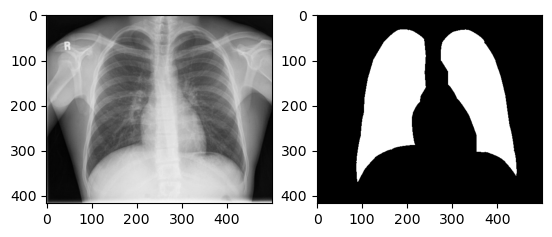

In [126]:
# read grayscale image and its mask
image = io.imread("./openist/1-10-500-500-100.jpg", as_gray=True)
print(image.shape, image.max(), image.min())

# read its mask
mask = io.imread("./openist/1-10-500-500-100@.png").astype(np.int64)
mask[mask != 0] = 1
print(mask.shape, mask.dtype, np.unique(mask))

fig, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(image, cmap='gray')
ax2.imshow(mask, cmap='gray')

## Read multi-channel multi-class (VOC)

(315, 275, 3) 255 11
(315, 275) int64 [0 1]


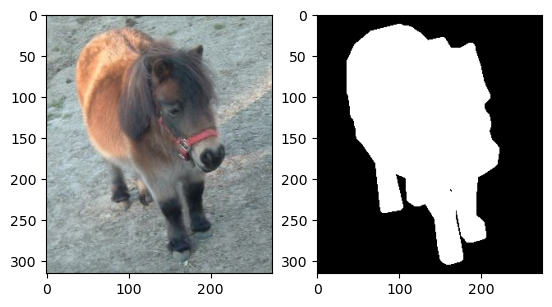

In [52]:
# read colorful image
image = io.imread("../Data/VOC2012/JPEGImages/2007_001724.jpg", as_gray=False)
print(image.shape, image.max(), image.min())

# read its mask
mask = io.imread("../Data/VOC2012/SegmentationObject/2007_001724.png").astype(np.int64)
mask = mask[:, :, 0]
mask[mask != 0] = 1
print(mask.shape, mask.dtype, np.unique(mask))

_, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(image)
ax2.imshow(mask, cmap='gray')

## Read multi-channel multi-class (RIM-ONE)

(462, 462, 3) 212 17
(462, 462) int64 [0 1 2]


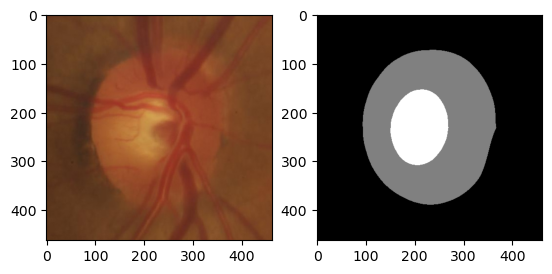

In [2]:
# read colorful image
image = io.imread("../Data/RIM-ONE/images/r1_Im001.png", as_gray=False)
print(image.shape, image.max(), image.min())

# read its mask
mask = io.imread("../Data/RIM-ONE/masks/r1_Im001.png", as_gray=True)
mask = (mask * 255).astype(np.int64)
print(mask.shape, mask.dtype, np.unique(mask))

_, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(image)
ax2.imshow(mask, cmap='gray')

# Update Data Transformation

## Get Data

In [90]:
# SELF_IMGS = [("./openist/1-10-500-500-100.jpg", "./openist/1-10-500-500-100@.png")]
# SELF_IMGS = [("../Data/VOC2012/JPEGImages/2007_001724.jpg", "../Data/VOC2012/SegmentationObject/2007_001724.png")]
SELF_IMGS = [("../Data/RIM-ONE/images/r1_Im001.png", "../Data/RIM-ONE/masks/r1_Im001.png")]
SELF_RESIZE_TO = (100, 100)

def get_data(index):
    img_path, msk_path = SELF_IMGS[index]

    # Reading images.
    img = io.imread(img_path)
    img = img_as_float(img)
    msk = io.imread(msk_path, as_gray=True)
    msk = msk / np.min(np.trim_zeros(np.unique(msk)))

    img = transform.resize(img, SELF_RESIZE_TO, order=1, preserve_range=True)
    msk = transform.resize(msk, SELF_RESIZE_TO, order=0, preserve_range=True)

    img = img.astype(np.float32)
    msk = np.round(msk).astype(np.int64)

    # Splitting path.
    spl = img_path.split('/')

    return img, msk, spl

(100, 100, 3) (100, 100) [0 1 2 3 4 5 6 7 8] ['..', 'Data', 'VOC2012', 'JPEGImages', '2007_001724.jpg']


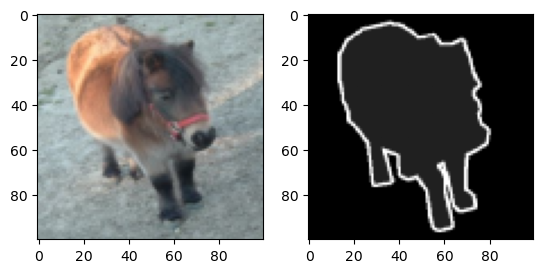

In [92]:
image, mask, splitted_path = get_data(0)
print(image.shape, mask.shape, np.unique(mask), splitted_path)

_, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(image)
ax2.imshow(mask, cmap='gray')

## Sparse Point

In [142]:
SELF_NUM_CLASSES = 3

def sparse_points(msk, sparsity='random', index=0):
    if sparsity != 'random':
        np.random.seed(index)
    
    # Linearizing mask.
    msk_ravel = msk.ravel()

    # Copying raveled mask and starting it with -1 for inserting sparsity.
    new_msk = np.zeros(msk_ravel.shape[0], dtype=np.int64)
    new_msk[:] = -1
    
    for c in range(SELF_NUM_CLASSES):
        # Slicing array for only containing class "c" pixels.
        msk_class = new_msk[msk_ravel == c]

        # Random permutation of class "c" pixels.
        perm = np.random.permutation(msk_class.shape[0])
        sparsity_num = round(sparsity) if sparsity != "random" else np.random.randint(low=1, high=len(perm))
        msk_class[perm[:min(sparsity_num, len(perm))]] = c

        # Merging sparse masks.
        new_msk[msk_ravel == c] = msk_class

    # Reshaping linearized sparse mask to the original 2 dimensions.
    new_msk = new_msk.reshape(msk.shape)

    return new_msk

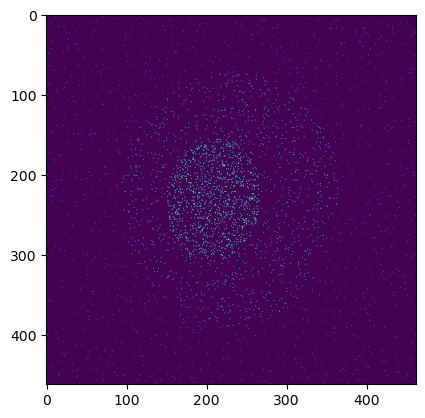

In [153]:
new_mask = sparse_points(mask, sparsity=1000)

plt.imshow(new_mask)

## Sparse Grid

In [227]:
def sparse_grid(msk, sparsity='random', index=0):
    # Copying mask and starting it with -1 for inserting sparsity.
    new_msk = np.zeros_like(msk)
    new_msk[:, :] = -1

    if sparsity == 'random':
        # Random sparsity (x and y point spacing).
        max_high = int(np.max(msk.shape)/2)
        spacing_value = np.random.randint(low=1, high=max_high)
        spacing = (spacing_value, spacing_value)

    else:
        # Predetermined sparsity (x and y point spacing).
        spacing = (int(2 ** sparsity),
                   int(2 ** sparsity))

        np.random.seed(index)

    starting = (np.random.randint(spacing[0]),
                np.random.randint(spacing[1]))

    new_msk[starting[0]::spacing[0], starting[1]::spacing[1]] = msk[starting[0]::spacing[0], starting[1]::spacing[1]]

    return new_msk

9


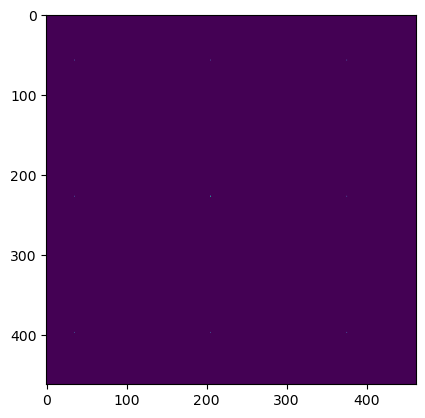

In [240]:
new_mask = sparse_grid(mask)

print(np.count_nonzero(new_mask != -1))
plt.imshow(new_mask)

## Sparse Contour

In [129]:
SELF_NUM_CLASSES = 3

def sparse_contour(msk, sparsity='random', index=0):
    sparsity_num = sparsity if sparsity != "random" else np.random.random()

    if sparsity != 'random':
        np.random.seed(index)

    new_msk = np.zeros_like(msk)

    # Random disk radius for erosions and dilations from the original mask.
    radius_dist = np.random.randint(low=4, high=10)

    # Random disk radius for annotation thickness.
    radius_thick = 1

    # Creating morphology elements.
    selem_dist = morphology.disk(radius_dist)
    selem_thick = morphology.disk(radius_thick)
    
    for c in range(SELF_NUM_CLASSES):
        # Eroding original mask and obtaining contours.
        msk_class = morphology.binary_erosion(msk == c, selem_dist)
        msk_contr = measure.find_contours(msk_class, 0.0)

        # Instantiating masks for the boundaries.
        msk_bound = np.zeros_like(msk)

        # Filling boundary masks.
        for _, contour in enumerate(msk_contr):
            rand_rot = np.random.randint(low=1, high=len(contour))
            for j, coord in enumerate(np.roll(contour, rand_rot, axis=0)):
                if j < max(1, min(round(len(contour) * sparsity_num), len(contour))):
                    msk_bound[int(coord[0]), int(coord[1])] = c+1

        # Dilating boundary masks to make them thicker.
        msk_bound = morphology.dilation(msk_bound, footprint=selem_thick)
        
        # Removing invalid boundary masks.
        msk_bound = msk_bound * (msk == c)

        # Merging boundary masks.
        new_msk += msk_bound
    
    return new_msk - 1

8029 [-1  0  1] (417, 500)


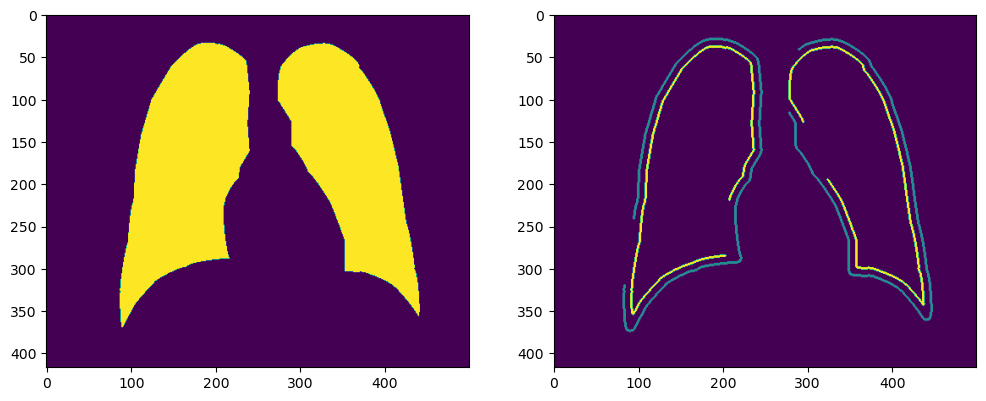

In [130]:
new_mask = sparse_contour(mask)
print(np.count_nonzero(new_mask != -1), np.unique(new_mask), new_mask.shape)

_, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(mask)
axs[1].imshow(new_mask)

## Sparse Region

In [122]:
SELF_DATASET = 'openist'
SELF_NUM_CLASSES = 3

def sparse_region(img, msk, sparsity='random', index=0):
    # Compactness of SLIC for each dataset.
    cpn = {
        # MEDICAL
        'nih_labeled': 0.6,
        'inbreast': 0.6,
        'shenzhen': 0.7,
        'montgomery': 0.5,
        'openist': 0.5,
        'jsrt': 0.5,
        'ufba': 0.5,
        'lidc_idri_drr': 0.5,
        'panoramic': 0.75,
        'mias': 0.45
    }

    if sparsity != "random":
        # Fixing seed.
        np.random.seed(index)

    sparsity_num = sparsity if sparsity != "random" else np.random.random()

    # Copying mask and starting it with -1 for inserting sparsity.
    new_msk = np.zeros_like(msk)
    new_msk[:] = -1

    # Computing SLIC super pixels.
    slic = segmentation.slic(
        img, n_segments=250, compactness=cpn[SELF_DATASET], start_label=1)
    labels = np.unique(slic)

    # Finding 'pure' regions, that is, the ones that only contain one label within.
    pure_regions = [[] for _ in range(SELF_NUM_CLASSES)]
    for l in labels:
        sp = msk[slic == l].ravel()
        cnt = np.bincount(sp)
    
        for c in range(SELF_NUM_CLASSES):
            if (cnt[c] if c < len(cnt) else None) == cnt.sum():
                pure_regions[c].append(l)
    
    for (c, pure_region) in enumerate(pure_regions):
        # Random permutation to pure region.
        perm = np.random.permutation(len(pure_region))

        # Only keeping the selected k regions.
        perm_last_idx = max(1, round(sparsity_num * len(perm)))
        for sp in np.array(pure_region)[perm[:perm_last_idx]]:
            new_msk[slic == sp] = c

    return new_msk

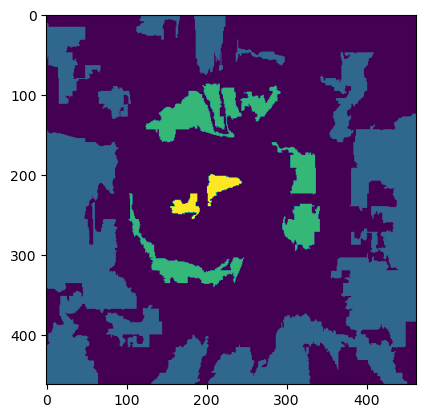

In [130]:
new_mask = sparse_region(image, mask, sparsity=0.5, index=1)
plt.imshow(new_mask)

## Sparse Skeleton

In [138]:
SELF_MODE = 'tune'
SELF_NUM_CLASSES = 3

def sparse_skels(msk, sparsity='random', index=0):
    sparsity_num = sparsity if sparsity != "random" else np.random.random()

    bseed = None  # Blobs generator seed
    if 'tune' in SELF_MODE:
        np.random.seed(index)
        bseed = index

    new_msk = np.zeros_like(msk)
    new_msk[:] = -1

    # Randomly selecting disk radius the annotation thickness.
    radius_thick = np.random.randint(low=1, high=2)
    selem_thick = morphology.disk(radius_thick)

    for c in range(SELF_NUM_CLASSES):
        c_msk = (msk == c)
        c_skel = morphology.skeletonize(c_msk)
        c_msk = morphology.binary_dilation(c_skel, footprint=selem_thick)

        new_msk[c_msk] = c

    blobs = skdata.binary_blobs(np.max(new_msk.shape), blob_size_fraction=0.1,
                                volume_fraction=sparsity_num, seed=bseed)
    blobs = blobs[:new_msk.shape[0], :new_msk.shape[1]]

    n_sp = np.zeros_like(new_msk)
    n_sp[:] = -1
    n_sp[blobs] = new_msk[blobs]

    return n_sp

(462, 462)


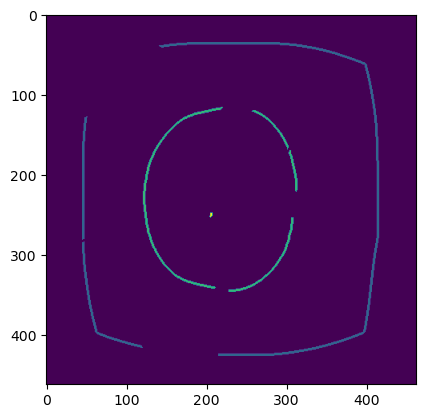

In [139]:
new_mask = sparse_skels(mask, 0.8)
print(new_mask.shape)
plt.imshow(new_mask)

## Image Normalization

In [42]:
def norm(img):
    normalized = np.zeros(img.shape)
    if len(img.shape) == 2:
        normalized = (img - img.mean()) / img.std()
    else:
        for b in range(img.shape[2]):
            normalized[:, :, b] = (img[:, :, b] - img[:, :, b].mean()) / img[:, :, b].std()
    return normalized

new_image = norm(image)
print(new_image.mean(axis=(0,1)), new_image.std(axis=(0,1)))

[-2.00688512e-14 -3.74939620e-15  4.49376324e-15] [1. 1. 1.]


## Image Dimension

In [41]:
def torch_channels(img):
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=0)
    else:
        img = np.moveaxis(img, -1, 0)
    return img

new_image = torch_channels(image)
print(image.shape, new_image.shape)

(462, 462, 3) (3, 462, 462)


# Check Training

## Load Stored Variable

In [5]:
tr_img = torch.load("./stored_var/tr_img.pt")
tr_msk = torch.load("./stored_var/tr_msk.pt")
tr_sparse_msk = torch.load("./stored_var/tr_sparse_msk.pt")
tr_pred = torch.load("./stored_var/tr_pred.pt")

ts_img = torch.load("./stored_var/ts_img.pt")
ts_msk = torch.load("./stored_var/ts_msk.pt")
ts_sparse_msk = torch.load("./stored_var/ts_sparse_msk.pt")
ts_pred = torch.load("./stored_var/ts_pred.pt")

## Check Prediction Evaluation

In [189]:
pt = tr_pred
yt = tr_msk

pred = pt.detach().max(1)[1].squeeze(1).squeeze(0).cpu().numpy()
label = yt.detach().squeeze(0).cpu().numpy()

print(pt.shape, pred.shape)
print(yt.shape, label.shape)

torch.Size([5, 2, 128, 128]) (5, 128, 128)
torch.Size([5, 128, 128]) (5, 128, 128)


In [190]:
pred_points =np.asarray([pred]).ravel()
label_points = np.asarray([label]).ravel()

print(pred_points.shape, label_points.shape)

metrics.jaccard_score(label_points, pred_points, average="weighted")

(81920,) (81920,)


0.8776280699941493

In [191]:
y_pred = [0, 2, 1, 2, 3, 2]
y_true = [0, 1, 2, 2, 3, 1]

print(metrics.jaccard_score(y_true, y_pred, average=None))
print(metrics.jaccard_score(y_true, y_pred, average="weighted"))

[1.   0.   0.25 1.  ]
0.4166666666666667


## Save Image

In [0]:
stored_dense_mask = tr_msk[0].cpu().squeeze().numpy()
stored_dense_mask = (stored_dense_mask * (255 / stored_dense_mask.max())).astype(np.uint8)
stored_sparse_mask = tr_sparse_msk[0].cpu().squeeze().numpy() + 1
stored_sparse_mask = (stored_sparse_mask * (255 / stored_sparse_mask.max())).astype(np.uint8)
io.imsave('mask_dense.png', stored_dense_mask)
io.imsave('mask_sparse.png', stored_sparse_mask)

In [9]:
def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

outp_path = './outputs/'
exp_name = 'maml_multiple_' + 'unet' + '_' + 'openist' + '_' + 'both_lungs' + '_f' + str(0)
check_mkdir(os.path.join(outp_path, exp_name, 'points' + '_train_epoch_' + str(10)))
io.imsave(os.path.join(outp_path, exp_name, 'points' + '_train_epoch_' + str(10), 'mask_dense.png'),
          stored_dense_mask)

## ProtoSeg

In [217]:
def get_num_samples(targets, num_classes, dtype=None):
    batch_size = targets.size(0)

    with torch.no_grad():
        num_samples = targets.new_zeros((batch_size, num_classes), dtype=dtype)

        for i in range(batch_size):
            trg_i = targets[i]

            for c in range(num_classes):
                num_samples[i, c] += trg_i[trg_i == c].size(0)

    return num_samples

In [272]:
def get_prototypes(embeddings, targets, num_classes):
    batch_size, embedding_size = embeddings.size(0), embeddings.size(-1)

    num_samples = get_num_samples(targets, num_classes, dtype=embeddings.dtype)
    num_samples.unsqueeze_(-1)
    num_samples = torch.max(num_samples, torch.ones_like(num_samples))

    prototypes = embeddings.new_zeros((batch_size, num_classes, embedding_size))
    indices = targets.unsqueeze(-1).expand_as(embeddings)

    for i in range(indices.size(0)):
        trg_i = targets[i]
        emb_i = embeddings[i]

        for c in range(num_classes):
            prototypes[i, c] += torch.sum(emb_i[trg_i == c], dim=0)

    prototypes.div_(num_samples)

    return prototypes

In [277]:
def prototypical_loss(prototypes, embeddings, targets, **kwargs):
    squared_distances = torch.sum((prototypes.unsqueeze(2)
                                   - embeddings.unsqueeze(1)) ** 2, dim=-1)
    return torch.nn.functional.cross_entropy(-squared_distances, targets, **kwargs)

In [278]:
def get_predictions(prototypes, embeddings):
    sq_distances = torch.sum((prototypes.unsqueeze(1)
                              - embeddings.unsqueeze(2)) ** 2, dim=-1)
    _, predictions = torch.min(sq_distances, dim=-1)
    return predictions

In [291]:
emb_train_linear = tr_pred.permute(0, 2, 3, 1).view(tr_pred.size(0), tr_pred.size(2) * tr_pred.size(3), tr_pred.size(1))
emb_test_linear = ts_pred.permute(0, 2, 3, 1).view(ts_pred.size(0), ts_pred.size(2) * ts_pred.size(3), ts_pred.size(1))

y_train_linear = tr_msk.view(tr_msk.size(0), -1)
y_test_linear = ts_msk.view(ts_msk.size(0), -1)

n_samples = get_num_samples(y_train_linear, 2)
protos = get_prototypes(emb_train_linear, y_train_linear, 2)
proto_loss = prototypical_loss(protos[:1], emb_test_linear, y_test_linear, ignore_index=-1)
pred_linear = get_predictions(protos, emb_test_linear)

print(n_samples)
print(protos.shape)
print(proto_loss)

tensor([[11650,  4734],
        [11515,  4869],
        [11454,  4930],
        [11454,  4930],
        [11454,  4930]])
torch.Size([5, 2, 2])
tensor(2.0944, grad_fn=<NllLoss2DBackward0>)


In [304]:
print(protos[:1].unsqueeze(2).shape)
print(emb_test_linear.unsqueeze(1).shape)
print((protos[:1].unsqueeze(2) - emb_test_linear.unsqueeze(1)).shape)
print(torch.sum(protos[:1].unsqueeze(2) - emb_test_linear.unsqueeze(1), dim=-1).shape)

torch.Size([1, 2, 1, 2])
torch.Size([1, 1, 16384, 2])
torch.Size([1, 2, 16384, 2])
torch.Size([1, 2, 16384])


In [307]:
print(protos.unsqueeze(1).shape)
print(emb_test_linear.unsqueeze(2).shape)
print((protos.unsqueeze(1) - emb_test_linear.unsqueeze(2)).shape)
print(torch.sum(protos.unsqueeze(1) - emb_test_linear.unsqueeze(2), dim=-1).shape)
print(torch.min(torch.sum(protos.unsqueeze(1) - emb_test_linear.unsqueeze(2), dim=-1), dim=-1)[1].shape)

torch.Size([5, 1, 2, 2])
torch.Size([1, 16384, 1, 2])
torch.Size([5, 16384, 2, 2])
torch.Size([5, 16384, 2])
torch.Size([5, 16384])


torch.Size([5, 16384]) torch.Size([5, 128, 128]) torch.Size([128, 128]) torch.Size([128, 128]) torch.Size([128, 128])
True


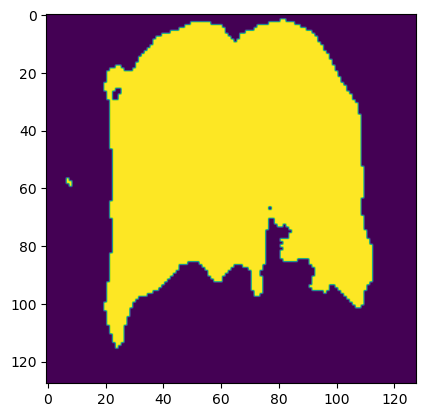

In [332]:
pred = pred_linear.view(pred_linear.size(0), ts_msk.size(1), ts_msk.size(2))

pred_sum = pred.sum(dim=0)
pred_full = pred_sum > (pred.size(0) / 2.0)

pred_final, _ = torch.mode(pred, dim=0)

print(pred_linear.shape, pred.shape, pred_sum.shape, pred_full.shape, pred_final.shape)
print(torch.equal(pred_full, pred_final))
plt.imshow(pred_final.numpy())

# Simple Checks

In [3]:
np.random.permutation(10)

array([0, 5, 8, 1, 9, 3, 6, 2, 7, 4])

In [12]:
torch.tensor([1, 2, 3, 4]).unsqueeze(-1).shape

torch.Size([4, 1])

In [205]:
torch.cat([torch.zeros((5,1,3,3)), torch.zeros((5,1,3,3))]).shape

torch.Size([10, 1, 3, 3])

In [2]:
pp, qq = 10, 11
print(pp, qq)

10 11


In [15]:
aa = torch.zeros([4, 65536, 2])
bb = torch.zeros([1, 65536, 2])

print(aa.shape, bb.shape)
torch.vstack((aa, bb)).shape

torch.Size([4, 65536, 2]) torch.Size([1, 65536, 2])


torch.Size([5, 65536, 2])